In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from math import sqrt
import warnings


### Основной класс

In [37]:
class TunnelingSolver:
    """
    Решатель для туннелирования через потенциальные барьеры произвольной формы
    """
    
    def __init__(self, a=2e-9, N=1000):
        """
        Инициализация решателя
        """
        # Физические константы
        self.hbar = 1.0545718e-34        # ℏ [Дж·с]
        self.m_electron = 9.1093837e-31  # масса электрона [кг]
        self.eV_to_J = 1.6021766e-19     # коэффициент перевода эВ в Дж
        
        # Параметры сетки
        self.a = a
        self.N = N
        self.x = np.linspace(0, a, N)
        self.dx = self.x[1] - self.x[0]
        
        # Потенциал и результаты
        self.U = None
        self.barrier_width = None
        self.transmission_results = {}
        self.current_barrier_type = None
        self.current_barrier_params = None
    
    def set_barrier(self, barrier_type, **params):
        """
        Задание потенциального барьера
        """
        self.current_barrier_type = barrier_type
        self.current_barrier_params = params.copy()
        
        if barrier_type == 'rectangular':
            U0_eV = params.get('U0_eV', 0.3)
            width = params.get('width', 1e-9)
            
            U0_J = U0_eV * self.eV_to_J
            self.U = np.zeros(self.N)
            inside_barrier = (self.x > (self.a - width)/2) & (self.x < (self.a + width)/2)
            self.U[inside_barrier] = U0_J
            self.barrier_width = width
            
        elif barrier_type == 'triangular':
            U0_eV = params.get('U0_eV', 0.3)
            width = params.get('width', 1e-9)
            asymmetry = params.get('asymmetry', 0.5)
            
            U0_J = U0_eV * self.eV_to_J
            self.U = np.zeros(self.N)
            barrier_center = self.a / 2
            barrier_start = barrier_center - width/2
            barrier_end = barrier_center + width/2
            
            left_mask = (self.x >= barrier_start) & (self.x < barrier_start + width * asymmetry)
            if np.any(left_mask):
                x_left = self.x[left_mask]
                self.U[left_mask] = U0_J * (x_left - barrier_start) / (width * asymmetry)
            
            right_mask = (self.x >= barrier_start + width * asymmetry) & (self.x <= barrier_end)
            if np.any(right_mask):
                x_right = self.x[right_mask]
                self.U[right_mask] = U0_J * (1 - (x_right - (barrier_start + width * asymmetry)) / (width * (1 - asymmetry)))
            
            self.barrier_width = width
            
        elif barrier_type == 'parabolic':
            U0_eV = params.get('U0_eV', 0.3)
            width = params.get('width', 1e-9)
            
            U0_J = U0_eV * self.eV_to_J
            center = self.a / 2
            
            self.U = np.zeros(self.N)
            barrier_mask = (self.x >= center - width/2) & (self.x <= center + width/2)
            x_centered = self.x[barrier_mask] - center
            self.U[barrier_mask] = U0_J * (1 - (x_centered / (width/2))**2)
            self.U = np.maximum(self.U, 0)
            self.barrier_width = width
            
        elif barrier_type == 'gaussian':
            U0_eV = params.get('U0_eV', 0.3)
            sigma = params.get('sigma', 0.2e-9)
            center = params.get('center', self.a/2)
            
            U0_J = U0_eV * self.eV_to_J
            self.U = U0_J * np.exp(-(self.x - center)**2 / (2 * sigma**2))
            self.barrier_width = 6 * sigma
            
        elif barrier_type == 'custom':
            if 'function' not in params:
                raise ValueError("Для произвольного барьера необходимо задать function")
            
            # Получаем значения от пользовательской функции
            U_values = params['function'](self.x)
            
            # Если функция возвращает значения в эВ, преобразуем в Джоули
            if params.get('units', 'eV') == 'eV':
                self.U = U_values * self.eV_to_J
            else:
                self.U = U_values
                
            self.barrier_width = params.get('width', 1e-9)
            
        else:
            raise ValueError(f"Неизвестный тип барьера: {barrier_type}")
    
    def _safe_integrate(self, func, a, b, max_attempts=3):
        """Безопасное интегрирование с обработкой ошибок"""
        for attempt in range(max_attempts):
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    integral, error = quad(func, a, b, limit=200, epsrel=1e-6, epsabs=1e-9)
                return integral, error
            except (Exception, Warning) as e:
                if attempt == max_attempts - 1:
                    # На последней попытке используем численное интегрирование
                    x_points = np.linspace(a, b, 1000)
                    y_points = [func(x) for x in x_points]
                    integral = np.trapz(y_points, x_points)
                    return integral, 1e-6
                continue
        return 0, 0
    
    def calculate_tunneling_probability(self, E, m_particle=None):
        """
        Вычисляет вероятность туннелирования через потенциальный барьер
        """
        if self.U is None:
            raise ValueError("Барьер не задан. Используйте set_barrier()")
        
        if m_particle is None:
            m_particle = self.m_electron
        
        def k_func(x):
            """Локальный волновой вектор"""
            U_val = np.interp(x, self.x, self.U)
            if U_val > E:
                return sqrt(2 * m_particle * (U_val - E)) / self.hbar
            else:
                return 0
        
        # Находим границы барьера, где U(x) > E
        barrier_regions = (self.U > E)
        
        if not np.any(barrier_regions):
            return 1.0, 0.0, []
        
        # Находим все непрерывные области барьера
        barrier_segments = []
        in_barrier = False
        segment_start = 0
        
        for i, is_barrier in enumerate(barrier_regions):
            if is_barrier and not in_barrier:
                segment_start = self.x[i]
                in_barrier = True
            elif not is_barrier and in_barrier:
                segment_end = self.x[i-1]
                barrier_segments.append((segment_start, segment_end))
                in_barrier = False
        
        if in_barrier:
            barrier_segments.append((segment_start, self.x[-1]))
        
        # Вычисляем полный интеграл для всех сегментов барьера
        total_integral = 0
        for segment in barrier_segments:
            x1, x2 = segment
            # Добавляем небольшие отступы от границ для стабильности
            margin = max((x2 - x1) * 0.01, 1e-12)
            integral, _ = self._safe_integrate(k_func, x1 + margin, x2 - margin)
            total_integral += integral
        
        # Коэффициент прохождения (вероятность туннелирования)
        D = np.exp(-2 * total_integral) if total_integral > 0 else 1.0
        R = 1 - D
        
        return D, R, barrier_segments
    
    def analyze_tunneling(self, E_eV, m_particle=None):
        """
        Полный анализ туннелирования для заданной энергии
        """
        E_J = E_eV * self.eV_to_J
        
        D, R, segments = self.calculate_tunneling_probability(E_J, m_particle)
        
        print(f"\n=== Анализ туннелирования ===")
        print(f"Энергия частицы: {E_eV:.3f} эВ")
        print(f"Коэффициент прохождения D = {D}")
        print(f"Коэффициент отражения  R = {R}")
        print(f"Вероятность туннелирования: {D*100:.4f}%")
        
        if segments:
            print(f"Области барьера (U(x) > E):")
            for i, seg in enumerate(segments):
                print(f"  Сегмент {i+1}: [{seg[0]*1e9:.2f}, {seg[1]*1e9:.2f}] нм")
        else:
            print("Нет классически запрещенных областей (полное прохождение)")
        
        # Сохраняем результаты
        self.transmission_results[E_eV] = {
            'D': D, 'R': R, 'segments': segments, 'E_J': E_J
        }
        
        return D, R, segments
    
    def plot_barrier_and_energy(self, E_eV=None, title=""):
        """
        Визуализация барьера и энергии частицы
        """
        if self.U is None:
            raise ValueError("Барьер не задан. Используйте set_barrier()")
        
        plt.figure(figsize=(12, 8))
        
        # Потенциал
        plt.plot(self.x * 1e9, self.U / self.eV_to_J, 'b-', linewidth=3, 
                label='Потенциальный барьер', alpha=0.8)
        
        # Энергия частицы
        if E_eV is not None:
            plt.axhline(E_eV, color='r', linestyle='--', linewidth=2, 
                       label=f'Энергия частицы: {E_eV:.3f} эВ')
            
            # Закрашиваем область барьера
            if E_eV in self.transmission_results:
                segments = self.transmission_results[E_eV]['segments']
                for i, seg in enumerate(segments):
                    x1, x2 = seg
                    x_seg = np.linspace(x1, x2, 100)
                    U_seg = np.interp(x_seg, self.x, self.U) / self.eV_to_J
                    label_text = 'Классически запрещенная область' if i == 0 else ""
                    plt.fill_between(x_seg * 1e9, U_seg, E_eV, alpha=0.3, 
                                   color='red', label=label_text)
            
            # Добавляем информацию о вероятности туннелирования
            if E_eV in self.transmission_results:
                D = self.transmission_results[E_eV]['D']
                plt.title(f'{title}\nВероятность туннелирования: {D*100:.4f}%')
        
        plt.xlabel('Положение, x (нм)')
        plt.ylabel('Энергия (эВ)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def energy_dependence_analysis(self, E_min_eV, E_max_eV, num_points=200, 
                                 m_particle=None, plot_log_scale=True):
        """
        Анализ зависимости вероятности туннелирования от энергии
        """
        energies_eV = np.linspace(E_min_eV, E_max_eV, num_points)
        transmission_probabilities = []
        
        for E_eV in energies_eV:
            D, _, _ = self.calculate_tunneling_probability(E_eV * self.eV_to_J, m_particle)
            transmission_probabilities.append(D)
        
        transmission_array = np.array(transmission_probabilities)
        
        # Находим энергию для 50% вероятности туннелирования
        target_prob = 0.5
        if np.any(transmission_array >= target_prob) and np.any(transmission_array <= target_prob):
            idx_50 = np.argmin(np.abs(transmission_array - target_prob))
            E_50_eV = energies_eV[idx_50]
        else:
            E_50_eV = E_max_eV
        
        print(f"\n=== Анализ зависимости от энергии ===")
        print(f"Энергия для 50% вероятности туннелирования: {E_50_eV:.3f} эВ")
        print(f"Диапазон энергий: {E_min_eV:.3f} - {E_max_eV:.3f} эВ")
        
        # Построение графика
        plt.figure(figsize=(12, 8))
        
        # Проверяем, есть ли положительные значения для логарифмической шкалы
        has_positive_values = np.any(np.array(transmission_probabilities) > 0)
        
        if plot_log_scale and has_positive_values:
            plt.semilogy(energies_eV, transmission_probabilities, 'b-', 
                        linewidth=2, label='Вероятность прохождения')
        else:
            plt.plot(energies_eV, transmission_probabilities, 'b-', 
                    linewidth=2, label='Вероятность прохождения')
            if plot_log_scale and not has_positive_values:
                print("Предупреждение: все значения вероятности равны 0, используется линейная шкала")
        
        plt.axhline(0.5, color='r', linestyle='--', alpha=0.7, label='50% вероятность')
        plt.axvline(E_50_eV, color='g', linestyle='--', alpha=0.7, 
                   label=f'E₅₀ = {E_50_eV:.3f} эВ')
        
        # Отмечаем высоту барьера
        U_max_eV = np.max(self.U) / self.eV_to_J
        plt.axvline(U_max_eV, color='orange', linestyle='--', alpha=0.7,
                   label=f'Макс. высота барьера = {U_max_eV:.3f} эВ')
        
        plt.xlabel('Энергия частицы, эВ')
        plt.ylabel('Коэффициент прохождения')
        plt.title('Зависимость вероятности туннелирования от энергии частицы')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return energies_eV, transmission_probabilities, E_50_eV
    
    def width_dependence_analysis(self, width_min_nm, width_max_nm, num_points=100,
                                E_eV=0.2, m_particle=None, plot_log_scale=True):
        """
        Анализ зависимости вероятности туннелирования от ширины барьера
        для текущего типа барьера
        """
        if self.current_barrier_type is None:
            raise ValueError("Сначала задайте барьер с помощью set_barrier()")
        
        widths_nm = np.linspace(width_min_nm, width_max_nm, num_points)
        transmission_vs_width = []
        
        # Сохраняем исходные параметры барьера
        original_params = self.current_barrier_params.copy()
        
        for width_nm in widths_nm:
            width_m = width_nm * 1e-9
            
            # Обновляем параметр ширины в зависимости от типа барьера
            if self.current_barrier_type == 'rectangular':
                self.set_barrier('rectangular', 
                               U0_eV=original_params.get('U0_eV', 0.3), 
                               width=width_m)
            elif self.current_barrier_type == 'triangular':
                self.set_barrier('triangular',
                               U0_eV=original_params.get('U0_eV', 0.3),
                               width=width_m,
                               asymmetry=original_params.get('asymmetry', 0.5))
            elif self.current_barrier_type == 'parabolic':
                self.set_barrier('parabolic',
                               U0_eV=original_params.get('U0_eV', 0.3),
                               width=width_m)
            elif self.current_barrier_type == 'gaussian':
                # Для гауссова барьера изменяем sigma пропорционально ширине
                # Сохраняем соотношение width = 6*sigma
                sigma = width_m / 6
                self.set_barrier('gaussian',
                               U0_eV=original_params.get('U0_eV', 0.3),
                               sigma=sigma,
                               center=original_params.get('center', self.a/2))
            elif self.current_barrier_type == 'custom':
                # Для произвольного барьера создаем новую функцию, которая масштабирует барьер в соответствии с новой шириной
                original_function = original_params['function']
                
                def scaled_custom_potential(x):
                    # Масштабируем координаты относительно новой ширины
                    scale_factor = width_m / original_params.get('width', 1e-9)
                    # Применяем масштабирование к координатам
                    x_scaled = (x - self.a/2) / scale_factor + self.a/2
                    return original_function(x_scaled)
                
                self.set_barrier('custom',
                               function=scaled_custom_potential,
                               width=width_m,
                               units=original_params.get('units', 'eV'))
            
            D, _, _ = self.calculate_tunneling_probability(E_eV * self.eV_to_J, m_particle)
            transmission_vs_width.append(D)
        
        # Восстанавливаем исходный барьер
        self.set_barrier(self.current_barrier_type, **original_params)
        
        # Построение графика
        plt.figure(figsize=(12, 8))
        
        # Проверяем, есть ли положительные значения для логарифмической шкалы
        has_positive_values = np.any(np.array(transmission_vs_width) > 0)
        
        if plot_log_scale and has_positive_values:
            plt.semilogy(widths_nm, transmission_vs_width, 'purple', linewidth=2)
        else:
            plt.plot(widths_nm, transmission_vs_width, 'purple', linewidth=2)
            if plot_log_scale and not has_positive_values:
                print("Предупреждение: все значения вероятности равны 0, используется линейная шкала")
        
        plt.xlabel('Ширина барьера, нм')
        plt.ylabel('Коэффициент прохождения')
        plt.title(f'Зависимость вероятности туннелирования от ширины барьера\n'
                 f'Тип барьера: {self.current_barrier_type}, Энергия частицы: {E_eV:.3f} эВ')
        plt.grid(True, alpha=0.3)
        
        # Добавляем информацию о барьере
        U_max_eV = np.max(self.U) / self.eV_to_J
        plt.figtext(0.02, 0.02, 
                   f'Макс. высота барьера: {U_max_eV:.3f} эВ\n'
                   f'Тип барьера: {self.current_barrier_type}',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7),
                   fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n=== Анализ зависимости от ширины барьера ===")
        print(f"Тип барьера: {self.current_barrier_type}")
        print(f"Энергия частицы: {E_eV:.3f} эВ")
        print(f"Диапазон ширины: {width_min_nm:.1f} - {width_max_nm:.1f} нм")
        print(f"Максимальная высота барьера: {U_max_eV:.3f} эВ")
        
        return widths_nm, transmission_vs_width


### Примеры барьеров

In [38]:
def rectangular_barrier():
    """Прямоугольный барьер"""
    print("=== ПРЯМОУГОЛЬНЫЙ БАРЬЕР ===")
    
    solver = TunnelingSolver(a=2e-9, N=1000)
    solver.set_barrier('rectangular', U0_eV=0.3, width=1e-9)
    
    # Анализ для конкретной энергии
    E_test_eV = 0.25
    D, R, segments = solver.analyze_tunneling(E_test_eV)
    
    # Визуализация
    solver.plot_barrier_and_energy(E_test_eV, "Прямоугольный потенциальный барьер")
    
    # Зависимость от энергии
    solver.energy_dependence_analysis(0.1, 0.4, 200)
    
    # Зависимость от ширины барьера
    widths, transmission = solver.width_dependence_analysis(
        0.5, 3.0, 50, E_eV=E_test_eV
    )
    
    return solver

def triangular_barrier():
    """Треугольный барьер"""
    print("\n=== ТРЕУГОЛЬНЫЙ БАРЬЕР ===")
    
    solver = TunnelingSolver(a=2e-9, N=1000)
    solver.set_barrier('triangular', U0_eV=0.35, width=1.2e-9, asymmetry=0.3)
    
    E_test_eV = 0.28
    D, R, segments = solver.analyze_tunneling(E_test_eV)
    solver.plot_barrier_and_energy(E_test_eV, "Треугольный потенциальный барьер")
    
    solver.energy_dependence_analysis(0.15, 0.45, 200)
    
    # Зависимость от ширины барьера
    widths, transmission = solver.width_dependence_analysis(
        0.5, 3.0, 50, E_eV=E_test_eV
    )
    
    return solver

def parabolic_barrier():
    """Параболический барьер"""
    print("\n=== ПАРАБОЛИЧЕСКИЙ БАРЬЕР ===")
    
    solver = TunnelingSolver(a=2e-9, N=1000)
    solver.set_barrier('parabolic', U0_eV=0.4, width=1e-9)
    
    E_test_eV = 0.3
    D, R, segments = solver.analyze_tunneling(E_test_eV)
    solver.plot_barrier_and_energy(E_test_eV, "Параболический потенциальный барьер")
    
    solver.energy_dependence_analysis(0.2, 0.5, 200)
    
    # Зависимость от ширины барьера
    widths, transmission = solver.width_dependence_analysis(
        0.5, 3.0, 50, E_eV=E_test_eV
    )
    
    return solver

def gaussian_barrier():
    """Гауссов барьер"""
    print("\n=== ГАУССОВ БАРЬЕР ===")
    
    solver = TunnelingSolver(a=2e-9, N=1000)
    solver.set_barrier('gaussian', U0_eV=0.35, sigma=0.3e-9, center=1e-9)
    
    E_test_eV = 0.25
    D, R, segments = solver.analyze_tunneling(E_test_eV)
    solver.plot_barrier_and_energy(E_test_eV, "Гауссов потенциальный барьер")
    
    solver.energy_dependence_analysis(0.1, 0.45, 200)
    
    # Зависимость от ширины барьера
    widths, transmission = solver.width_dependence_analysis(
        0.5, 3.0, 50, E_eV=E_test_eV
    )
    
    return solver

def custom_barrier():
    """Произвольный барьер"""
    print("\n=== ПРОИЗВОЛЬНЫЙ БАРЬЕР ===")
    
    def custom_potential(x):
        # Сложный барьер с тремя гауссовыми пиками
        U1 = 0.25 * np.exp(-(x - 0.5e-9)**2 / (2 * (0.15e-9)**2))
        U2 = 0.3 * np.exp(-(x - 1.0e-9)**2 / (2 * (0.2e-9)**2))
        U3 = 0.2 * np.exp(-(x - 1.5e-9)**2 / (2 * (0.1e-9)**2))
        return U1 + U2 + U3  # Возвращаем в эВ
    
    solver = TunnelingSolver(a=2e-9, N=1000)
    
    # Указываем, что функция возвращает значения в эВ
    solver.set_barrier('custom', function=custom_potential, width=1.5e-9, units='eV')
    
    E_test_eV = 0.2
    D, R, segments = solver.analyze_tunneling(E_test_eV)
    solver.plot_barrier_and_energy(E_test_eV, "Произвольный потенциальный барьер (три гауссовых пика)")
    
    # Используем более широкий диапазон энергий
    solver.energy_dependence_analysis(0.05, 0.5, 200)
    
    # Зависимость от ширины барьера
    widths, transmission = solver.width_dependence_analysis(
        0.5, 3.0, 50, E_eV=E_test_eV
    )
    
    return solver



=== ПРОИЗВОЛЬНЫЙ БАРЬЕР ===

=== Анализ туннелирования ===
Энергия частицы: 0.200 эВ
Коэффициент прохождения D = 0.19272330160333148
Коэффициент отражения  R = 0.8072766983966685
Вероятность туннелирования: 19.2723%
Области барьера (U(x) > E):
  Сегмент 1: [0.40, 0.70] нм
  Сегмент 2: [0.75, 1.18] нм
  Сегмент 3: [1.45, 1.53] нм


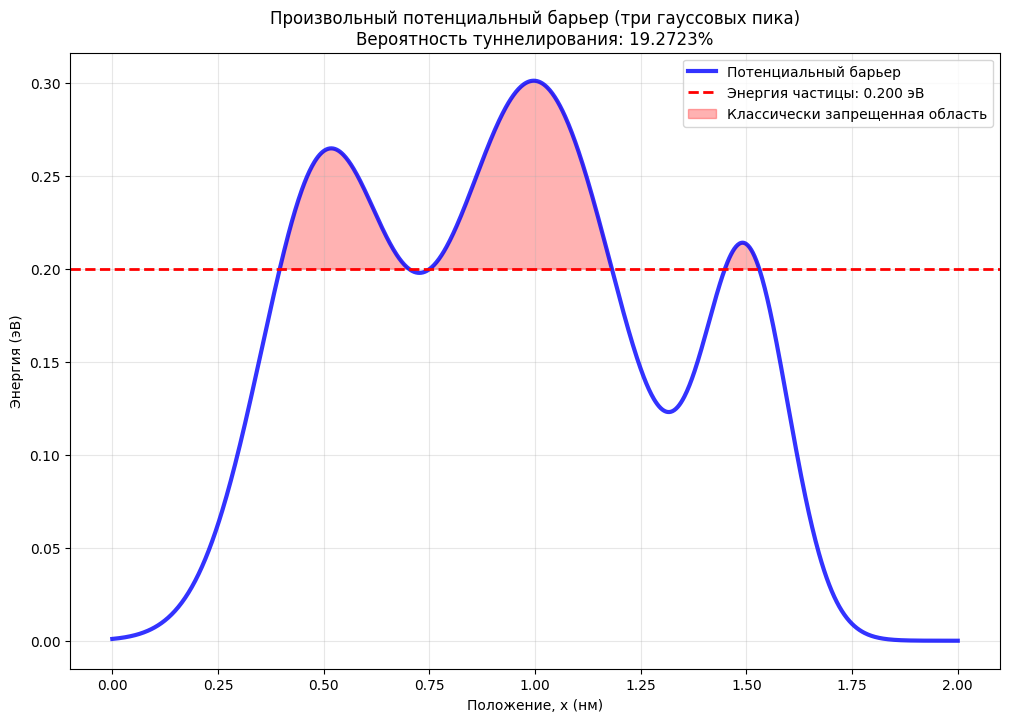


=== Анализ зависимости от энергии ===
Энергия для 50% вероятности туннелирования: 0.242 эВ
Диапазон энергий: 0.050 - 0.500 эВ


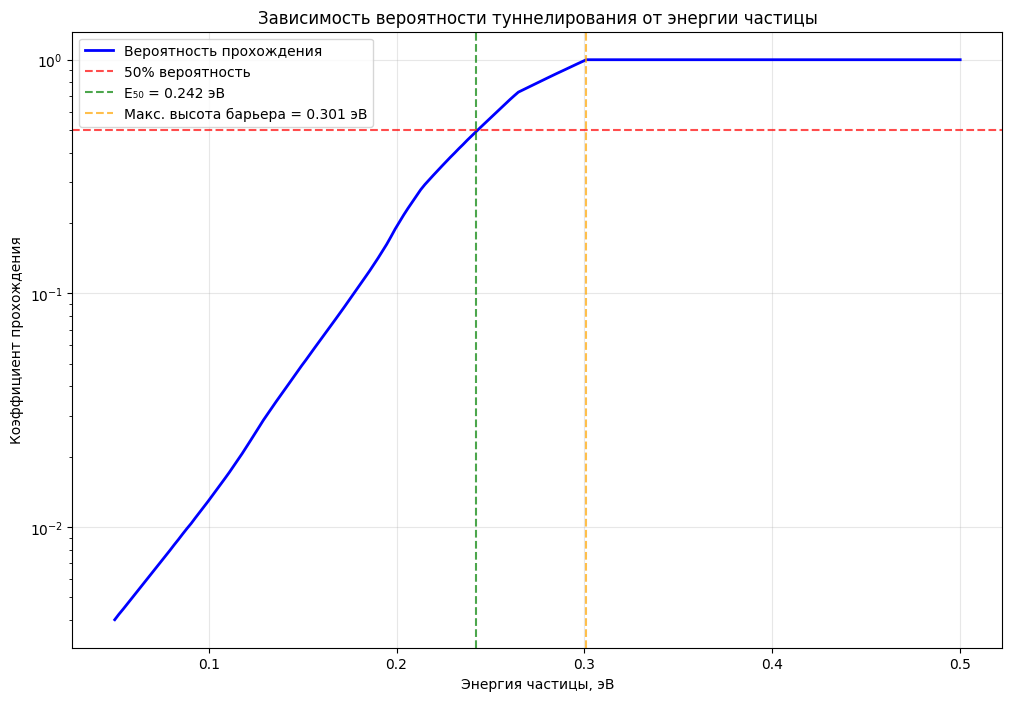

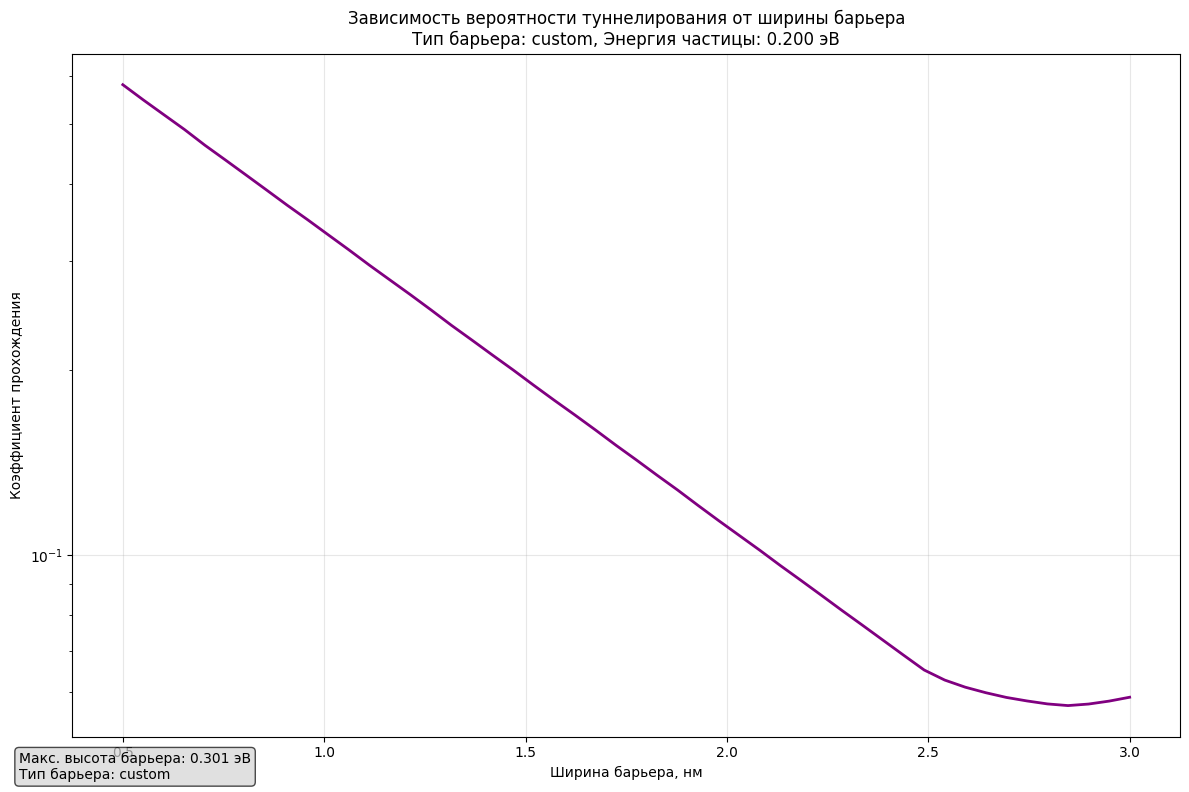


=== Анализ зависимости от ширины барьера ===
Тип барьера: custom
Энергия частицы: 0.200 эВ
Диапазон ширины: 0.5 - 3.0 нм
Максимальная высота барьера: 0.301 эВ


In [39]:
solver_custom = custom_barrier()

In [40]:
# solver_rect = rectangular_barrier()
# solver_tri = triangular_barrier()
# solver_par = parabolic_barrier()
# solver_gauss = gaussian_barrier()